In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image 
import os
import random
import cv2

import tensorflow as tf
import keras 
from sklearn.model_selection import train_test_split 
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.callbacks import ModelCheckpoint
from keras.layers import Flatten, BatchNormalization, GlobalAveragePooling2D, MaxPool2D

In [ ]:
#read_file = pd.read_excel(r'C:\Users\anndz\Desktop\BP\COVID.metadata.xlsx')
#read_file.to_csv(r'C:\Users\anndz\Desktop\BP\COVID.metadata.csv', index = None, header=True)
#COVID = read_file

Predspracovanie

In [2]:
Ycat = []
Ybin = []
labels = ['Normal', 'Lung_Opacity','Viral_Pneumonia','Tuberculosis','COVID']
size = 256

def get_data(folder, Ycat, Ybin):
    x = 0
    data = []
    for label in labels: 
        path = os.path.join(folder, label)
        for images in os.listdir(path):
            img = cv2.imread(os.path.join(folder,label, images))[...,::-1]
            img = cv2.resize(img, (size, size))
            img = img.astype('float16')
            img /= 255
            data.append(img)
            Ycat.append(label)
            if label == 'COVID':
                Ybin.append(1)
            else:
                Ybin.append(0)
        x = x + 1
    return data

In [3]:
Xdata = get_data('',Ycat, Ybin)

In [4]:
#Xdata = Xdata.sample(n=len(Xdata), random_state=1242)
#Ycat = Ycat.sample(n=len(Ycat), random_state=1242)
random.seed(151)
Xdata = random.sample(Xdata,len(Xdata))#3600)
random.seed(151)
Ycat=random.sample(Ycat,len(Ycat))#3600)
random.seed(151)
Ybin=random.sample(Ybin,len(Ybin))#3600)
X = np.array(Xdata)
Ycat = np.array(Ycat)
Ybin = np.array(Ybin)

In [ ]:
print(Ybin)

In [ ]:
#Ycat = utils.to_categorical(labels,5)

Binary

In [5]:
xBin_train, xBin_test, yBin_train, yBin_test = train_test_split(X, Ybin, test_size=0.3, random_state=1)

In [ ]:
print(len(xBin_test),len(xBin_train))

In [6]:
model = Sequential()

model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,3)))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 flatten (Flatten)           (None, 2097152)           0         
                                                                 
 dense (Dense)               (None, 128)               268435584 
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 268,436,738
Trainable params: 268,436,738
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

In [7]:
from tensorflow.keras.optimizers import Adam

adam = Adam()
#model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=adam, metrics=['accuracy'])

In [8]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [9]:
history = model.fit(xBin_train, yBin_train, epochs=5, validation_data=(xBin_test, yBin_test),callbacks=[checkpoint])

Epoch 1/5


C:\Anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


479/479 [==============================] - ETA: 0s - loss: 3.9973 - accuracy: 0.8796
Epoch 00001: val_loss improved from inf to 0.20315, saving model to model.h5
479/479 [==============================] - 1221s 3s/step - loss: 3.9973 - accuracy: 0.8796 - val_loss: 0.2031 - val_accuracy: 0.9218
Epoch 2/5
479/479 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9369
Epoch 00002: val_loss did not improve from 0.20315
479/479 [==============================] - 1293s 3s/step - loss: 0.1769 - accuracy: 0.9369 - val_loss: 0.2593 - val_accuracy: 0.9062
Epoch 3/5
479/479 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9399
Epoch 00003: val_loss did not improve from 0.20315
479/479 [==============================] - 1334s 3s/step - loss: 0.1643 - accuracy: 0.9399 - val_loss: 0.2320 - val_accuracy: 0.9191
Epoch 4/5
479/479 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9630
Epoch 00004: val_loss improved from 0.20315 to 0.198

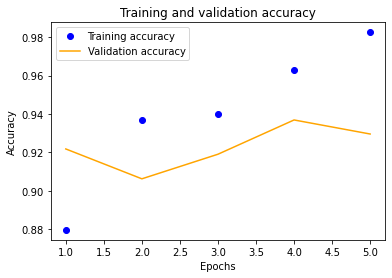

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = np.argmax(model.predict(xBin_test), 1)
#predictions = model.predict(xBin_test)
#predictions = predictions.reshape(1,-1)[0]

In [ ]:
print(xBin_test.shape, predictions.shape)

In [13]:
print(classification_report(yBin_test, predictions, target_names = ['Non-COVID (Class 0)','COVID (Class 1)']))

                     precision    recall  f1-score   support

Non-COVID (Class 0)       0.97      0.95      0.96      5449
    COVID (Class 1)       0.76      0.85      0.80      1111

           accuracy                           0.93      6560
          macro avg       0.87      0.90      0.88      6560
       weighted avg       0.93      0.93      0.93      6560



In [14]:
print('Confusion matrix : \n')
print(confusion_matrix(yBin_test, predictions)) #(actual, predicted)

Confusion matrix : 

[[5154  295]
 [ 167  944]]


Categorical

In [ ]:
print(x_train.shape, x_test.shape,y_train.shape, y_test.shape)

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(256,256,3)))

model.add(MaxPooling2D(pool_size=(2,2))),

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))

model.summary()

In [ ]:
adam = Adam()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=adam, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
f = model.fit(x_train, y_train, epochs = 3,batch_size=128, validation_data=(x_test, y_test))

In [ ]:
acc = f.history['accuracy']
val_acc = f.history['val_accuracy']
loss = f.history['loss']
val_loss = f.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print(x_test.shape,y_test.shape)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = model.predict(x_test)
predicted = np.argmax(predictions, axis = 1)

In [ ]:
predicted

In [ ]:
results={
   0:'Normal',
   1:'Lung_Opacity',
   2:'Viral_Pneumonia',
   3:'Tuberculosis',
   4:'COVID',
}

In [ ]:
#print(pd.crosstab(y_test, predicted))
print(pd.crosstab(y_test, predicted))

In [ ]:
print(classification_report(y_test, predicted))#,labels = labels, target_names = ['Normal', 'Lung_Opacity','Viral_Pneumonia','Tuberculosis','COVID']))